<h1>Prototyp FFT</h1>
Erstellt am 12.04.2022 von Christian T. Seidler
<br>Zweck: Anwendung der FFT auf Messungen des FEMTO Bearing Datensatzes.

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy import fftpack

import matplotlib.pyplot as plt
import time
import os

In [67]:
# Datenpfad anlegen
path = r'D:\HS Albstadt\Sommersemester 2022\Machine Learning in Manufacturing\Projektarbeit\Datensatz\Test_set'

learning_sets = {'Bearing1_1': 2803,
                 'Bearing1_2': 871,
                 'Bearing2_1': 911,
                 'Bearing2_2': 797,
                 'Bearing3_1': 515,
                 'Bearing3_2': 1637}

test_sets = {'Bearing1_3': 1802,
             'Bearing1_4': 1139,
             'Bearing1_5': 2302,
             'Bearing1_6': 2302,
             'Bearing1_7': 1502,
             'Bearing2_3': 1202,
             'Bearing2_4': 612,
             'Bearing2_5': 2002,
             'Bearing2_6': 572,
             'Bearing2_7': 172,
             'Bearing3_3': 352}

In [3]:
# Funktion, um eine Messung einzulesen und als pd.Dataframe zurückzugeben
def read_single_measurement(filepath):
    # Nur die letzten beiden Spalten einlesen, da diese die Messdaten in x- und y-Richtung enthalten
    measurement = pd.read_csv(filepath, sep=',', header=None, usecols=[4, 5])
    
    # Header umbenennen
    measurement.rename(columns={4: 'acc_x', 5: 'acc_y'}, inplace=True)
    
    return measurement

In [191]:
# Funktion, um die FFT anzuwenden
def perform_fft(input_df, windowing=False):
    f_s = 25600
    
    x = list(input_df['acc_x'])
    y = list(input_df['acc_y'])
    
    # Window anlegen
    win_x = np.kaiser(len(x), 5)
    win_y = np.kaiser(len(y), 5)
    
    if windowing:
        X = fftpack.fft(x * win_x)
        freqs_x = fftpack.fftfreq(len(x)) * f_s
        
        Y = fftpack.fft(y * win_y)
        freqs_y = fftpack.fftfreq(len(y)) * f_s
    else:
        # in x-Richtung
        X = fftpack.fft(x)
        freqs_x = fftpack.fftfreq(len(x)) * f_s

        # in y-Richtung
        Y = fftpack.fft(y)
        freqs_y = fftpack.fftfreq(len(y)) * f_s
    
    return X, freqs_x, Y, freqs_y

In [109]:
# Funktion, um die Frequenz mit der größten Magnitude aus dem Frequenzspektrum zu extrahieren
def extract_max_freq(X, freqs_x): 
    # Umwandeln der Eingangsdaten in Listen
    x = list(np.abs(X))
    freqs = list(freqs_x)
    
    # maximale Magnitude bestimmen
    max_x = max(x)
    
    # Index der Frequenz mit der größten Magnitude bestimmen
    index_max_x = x.index(max(x))
    
    # zugehörige Frequenz extrahieren
    max_freq = freqs[index_max_x]
    
    return max_freq

In [110]:
# Funktion, um die Frequenz mit der größten Magnitude aus dem Frequenzspektrum zu entfernen
# Funktioniert nicht immer richtig
def remove_max_freq(X, freqs_x):
    # Umwandeln der Eingangsdaten in Listen
    x = list(np.abs(X))
    freqs = list(freqs_x)
    
    # maximale Magnitude bestimmen
    max_x = max(x)
    
    # Index der Frequenz mit der größten Magnitude bestimmen
    index_max_x = x.index(max(x))

    # Entfernen der maximalen Frequenz
    del x[index_max_x]
    del freqs[index_max_x]

    # Wiederholen für die Spiegelfrequenz
    # maximale Magnitude bestimmen
    max_x = max(x)
    
    # Index der Frequenz mit der größten Magnitude bestimmen
    index_max_x = x.index(max(x))
    
    # Entfernen der 2. maximalen Frequenz - ist die Spiegelfrequenz der 1. Frequenz
    del x[index_max_x]
    del freqs[index_max_x]

    return x, freqs

In [196]:
# Funktion, um automatisiert alle Messungen einzulesen und die maximale Frequenz zu extrahiere
def read_bearing_measurements_with_fft(filepath, start=1, end=1, step=1):
    data = pd.DataFrame()
    
    # Filepath automatisiert anpassen
    for i in range(start, end+1, step):        
        if i < 10:
            document = r'\acc_0000' + str(i) + '.csv'
        elif 10 <= i < 100:
            document = r'\acc_000' + str(i) + '.csv'
        elif 100 <= i < 1000:
            document = r'\acc_00' + str(i) + '.csv'
        else:
            document = r'\acc_0' + str(i) + '.csv'
            
        path = filepath + document

        # Messdaten einlesen
        input_df = read_single_measurement(path)
        
        # Extrahieren der maximalen Frequenz aus den Messdaten mittels FFT
        X, freqs_x, Y, freqs_y = perform_fft(input_df, windowing=False)
        
        # Bestimmen der maximalen Frequenz -- 1
        #max_freq_x = extract_max_freq(X, freqs_x)
        #max_freq_y = extract_max_freq(Y, freqs_y)
        
        # Bestimmen der 5 Frequenzanteile mit der größten Magnitude
        # In x-Richtung
        # Quelle: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        max_freqs_index_x = np.argpartition(np.abs(X), -10)[-10:]
        max_freqs_value_x = freqs_x[max_freqs_index_x]
        max_freqs_value_x = max_freqs_value_x[np.argsort(freqs_x[max_freqs_index_x])]
        max_freqs_list_x = list(max_freqs_value_x)
        # Negative Frequenzen entfernen
        del max_freqs_list_x[0:5]
        
        # In y-Richtung
        max_freqs_index_y = np.argpartition(np.abs(Y), -10)[-10:]
        max_freqs_value_y = freqs_y[max_freqs_index_y]
        max_freqs_value_y = max_freqs_value_y[np.argsort(freqs_y[max_freqs_index_y])]
        max_freqs_list_y = list(max_freqs_value_y)
        # Negative Frequenzen entfernen
        del max_freqs_list_y[0:5]
        
        # Maximale Frequenzen in DataFrame umwandeln
        frequency_df = pd.DataFrame({'Observation': [], 'max_freq_1_x': [], 'max_freq_2_x': [], 'max_freq_3_x': [],
                                     'max_freq_4_x': [], 'max_freq_5_x': [], 'max_freq_1_y': [], 'max_freq_2_y': [],
                                     'max_freq_3_y': [], 'max_freq_4_y': [], 'max_freq_5_y': []})
        frequency_df.loc[0] = [i, max_freqs_list_x[-1], max_freqs_list_x[-2], max_freqs_list_x[-3],
                               max_freqs_list_x[-4], max_freqs_list_x[-5], max_freqs_list_y[-1],
                               max_freqs_list_y[-2], max_freqs_list_y[-3], max_freqs_list_y[-4],
                               max_freqs_list_y[-5]]
        
        
        # Maximale Frequenzen in DataFrame umwandeln
        # frequency_df = pd.DataFrame({'Observation': [], 'max_freq_x': [], 'max_freq_y': []})
        # frequency_df.loc[0] = [i, max_freq_x, max_freq_y]
        
        # Anhängen der Daten an den DataFrame
        data = pd.concat([data, frequency_df], ignore_index=True)
        
    return data    

In [7]:
# Funktion, um grundlegende Informationen eines Dataframes auszugeben
def print_df_infos(df):
    print(df.describe(), end='\n\n')
    print(df.head(), end='\n\n')
    print(df.tail(), end='\n\n')
    print(df.info(), end='\n\n')

In [197]:
file = os.path.join(path, 'Test_set', 'Bearing1_3')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements_with_fft(file, start=1, end=test_sets['Bearing1_3'], step=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
print_df_infos(data)

Execution Time [s]: 16.801783800125122

       Observation  max_freq_1_x  max_freq_2_x  max_freq_3_x  max_freq_4_x  \
count   1802.00000   1802.000000   1802.000000   1802.000000   1802.000000   
mean     901.50000   2108.962264   1620.554939   1226.348502    835.632630   
std      520.33691   1148.477195    882.216193    751.262780    603.554771   
min        1.00000    320.000000    180.000000    120.000000     60.000000   
25%      451.25000   1040.000000   1010.000000    970.000000    340.000000   
50%      901.50000   2430.000000   1050.000000   1020.000000    965.000000   
75%     1351.75000   2870.000000   2630.000000   1067.500000   1030.000000   
max     1802.00000  11850.000000   4590.000000   3510.000000   3440.000000   

       max_freq_5_x  max_freq_1_y  max_freq_2_y  max_freq_3_y  max_freq_4_y  \
count   1802.000000   1802.000000   1802.000000   1802.000000   1802.000000   
mean     401.814650   7273.396226   7052.114317   6873.174251   6486.709212   
std      431.348599 

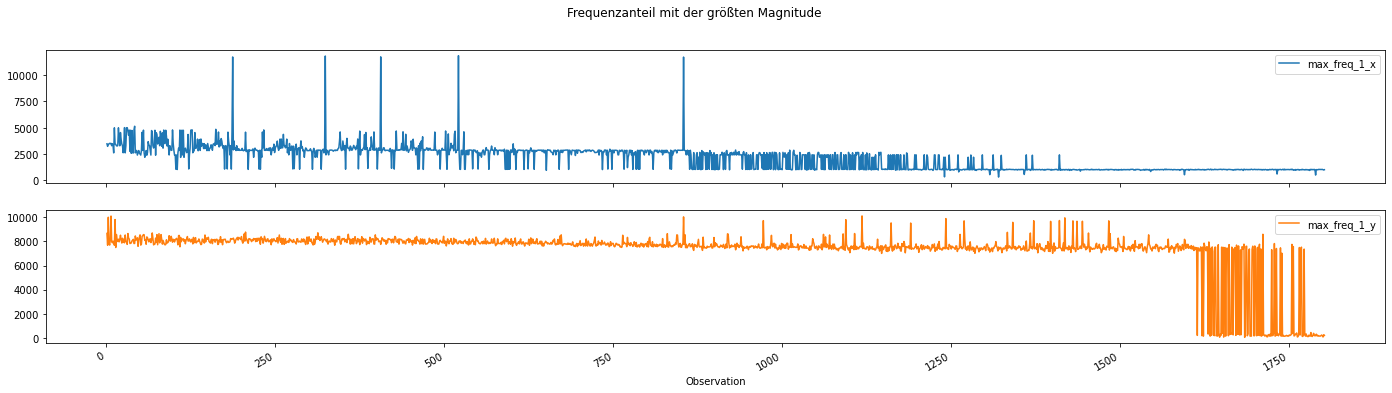

In [198]:
# Grafische Darstellung des stärksten Frequenzanteils
# %matplotlib notebook
%matplotlib inline
data.plot(x='Observation', y=['max_freq_1_x', 'max_freq_1_y'], title='Frequenzanteil mit der größten Magnitude',
          legend=True, figsize=(24, 6), subplots=True)
plt.show()

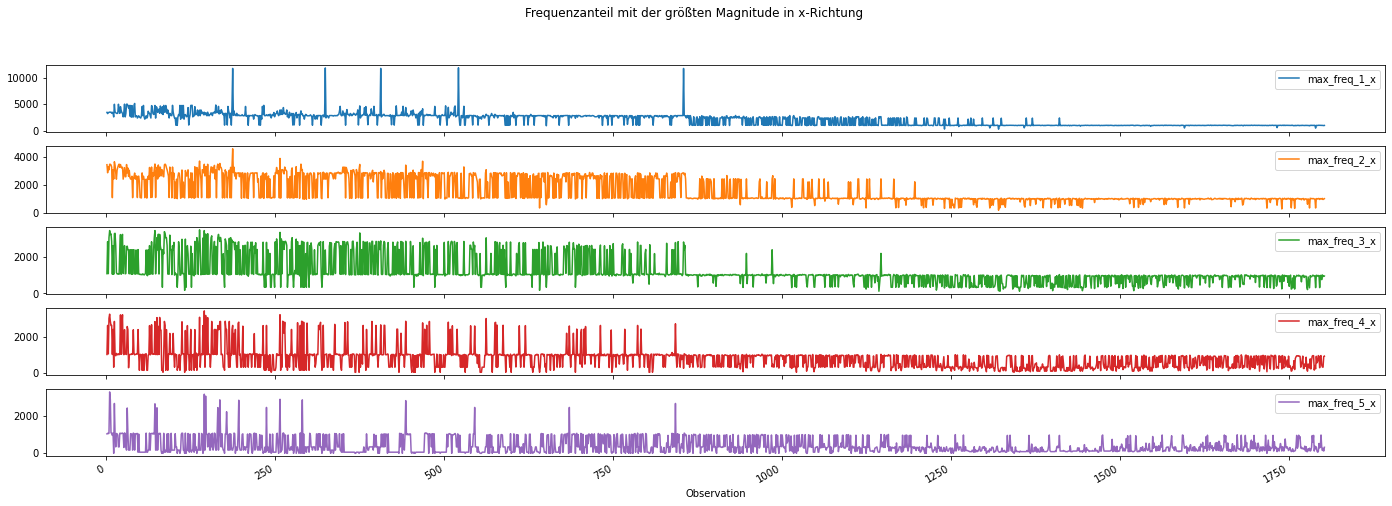

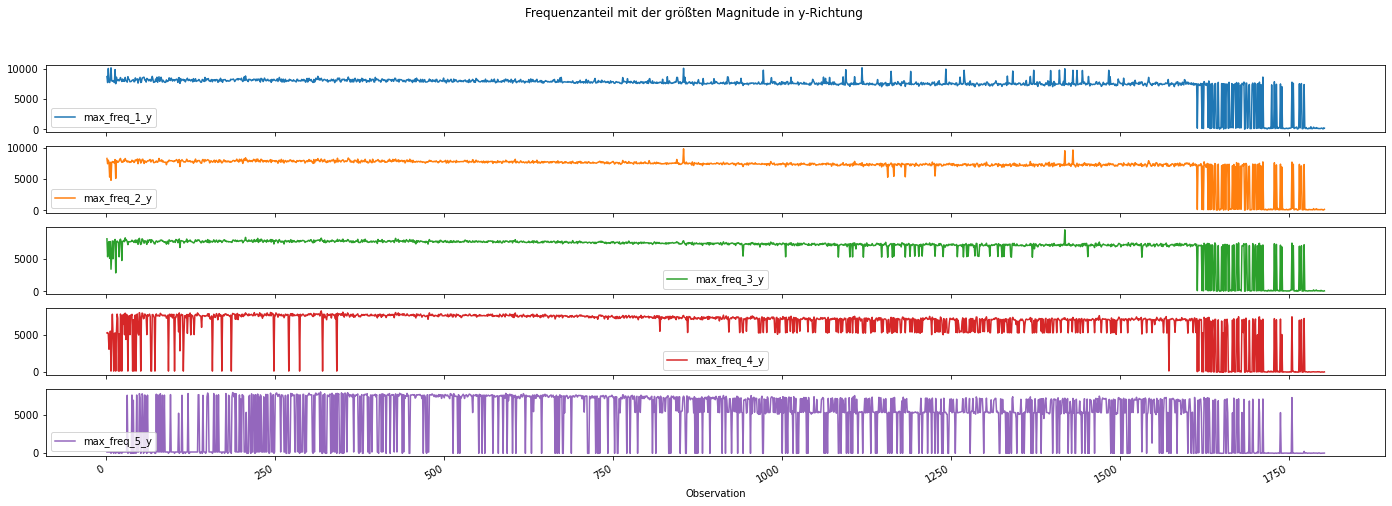

In [199]:
# Grafische Darstellung der 5 stärksten Frequenzanteile
# in x-Richtung
# %matplotlib notebook
%matplotlib inline
data.plot(x='Observation', y=['max_freq_1_x', 'max_freq_2_x', 'max_freq_3_x', 'max_freq_4_x', 'max_freq_5_x'], 
          title='Frequenzanteil mit der größten Magnitude in x-Richtung',
          legend=True, figsize=(24, 8), subplots=True)
plt.show()

# in y-Richtung
# %matplotlib notebook
%matplotlib inline
data.plot(x='Observation', y=['max_freq_1_y', 'max_freq_2_y', 'max_freq_3_y', 'max_freq_4_y', 'max_freq_5_y'], 
          title='Frequenzanteil mit der größten Magnitude in y-Richtung',
          legend=True, figsize=(24, 8), subplots=True)
plt.show()

<h3>Anwendung der FFT auf eine einzige Messung</h3>

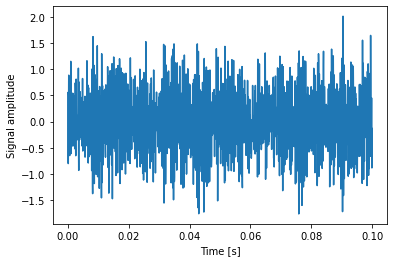

In [147]:
# Zeitsignal anzeigen
t = list(range(0, len(data['acc_x'])))
t = [x / 25600 for x in t]
x = list(data['acc_x'])

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

(-12800.0, 12800.0)

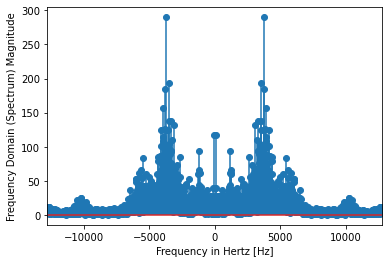

In [150]:
# Berechnung und Anzeige der FFT für das zeitliche Signal
from scipy import fftpack
f_s = 25600

X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X), use_line_collection=True)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
# ax.set_ylim(-5, 110)

<h3>Test zum manuellen Extrahieren des Frequenzanteils mit der größten Magnitude</h3>

In [151]:
# Extrahieren der maximalen Frequenz
test = list(np.abs(X))
freqs = list(freqs)
print(max(test))
print(test.index(max(test)))
print(len(test))
print(len(freqs))
print(freqs[375])
print('\n\n')

# Extrahieren der 2. maximalen Frequenz - ist die Spiegelfrequenz der 1. Frequenz
del test[375]
del freqs[375]

print(max(test))
print(test.index(max(test)))
print(len(test))
print(len(freqs))
print(freqs[2184])
print('\n\n')

# Extrahieren der 3. stärksten Frequenz
del test[2184]
del freqs[2184]

print(max(test))
print(test.index(max(test)))
print(len(test))
print(len(freqs))
print(freqs[353])

289.8932083898847
375
2560
2560
3750.0



289.8932083898847
2184
2559
2559
-3750.0



192.8455259470181
353
2558
2558
3530.0000000000005


<h3>Manuelle Erstellung eines Spektrogramms für eine einzige Messung</h3>

In [113]:
# Erweiterung
from skimage import util

x = np.array(x)
M = 1024

slices = util.view_as_windows(x, window_shape=(M,), step=100)
print(f'Acc_x shape: {x.shape}, Sliced acc_x shape: {slices.shape}')

Acc_x shape: (2560,), Sliced acc_x shape: (16, 1024)


In [114]:
win = np.hanning(M + 1)[:-1]
slices = slices * win

In [115]:
slices = slices.T
print('Shape of `slices`:', slices.shape)

Shape of `slices`: (1024, 16)


In [116]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

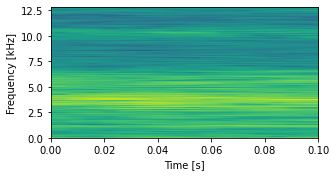

In [117]:
L = len(data['acc_x']) / f_s

f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, f_s / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

<h3>Automatische Variante zur Erstellung eines Spektrogramms</h3>

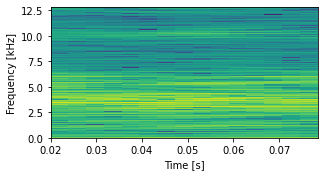

In [118]:
# Spektogramm direkt erstellen
# The only differences between the manual spectrogram that we created versus the SciPy’s built-in function are that
# SciPy returns the spectrum magnitude squared
from scipy import signal

freqs, times, Sx = signal.spectrogram(x, fs=f_s, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

<h3>Verwendung von Windowing</h3>

In [170]:
# Funktion, um automatisiert alle Messungen einzulesen
def read_bearing_measurements(filepath, start=1, end=1, step=1):
    data = pd.DataFrame()
    
    # Filepath automatisiert anpassen
    for i in range(start, end+1, step):
        if i < 10:
            document = r'\acc_0000' + str(i) + '.csv'
        elif 10 <= i < 100:
            document = r'\acc_000' + str(i) + '.csv'
        elif 100 <= i < 1000:
            document = r'\acc_00' + str(i) + '.csv'
        else:
            document = r'\acc_0' + str(i) + '.csv'
            
        path = filepath + document

        # Messdaten einlesen
        input_df = read_single_measurement(path)
        
        # Anhängen der Daten an den DataFrame
        data = pd.concat([data, input_df], ignore_index=True)
        
    return data    

In [172]:
file = os.path.join(path, 'Learning_set', 'Bearing1_1')

# Zeit der Ausführung stoppen
start = time.time()
data = read_bearing_measurements(file, start=1, end=1)
end = time.time()
print("Execution Time [s]:", end - start, end='\n\n')
print_df_infos(data)

Execution Time [s]: 0.015958309173583984

             acc_x        acc_y
count  2560.000000  2560.000000
mean      0.003465    -0.001881
std       0.561845     0.435883
min      -1.763000    -1.569000
25%      -0.383250    -0.300500
50%       0.002500    -0.007000
75%       0.383250     0.296000
max       2.010000     1.591000

   acc_x  acc_y
0  0.552 -0.146
1  0.501 -0.480
2  0.138  0.435
3 -0.423  0.240
4 -0.802  0.020

      acc_x  acc_y
2555  0.044 -0.094
2556 -0.456  0.486
2557 -0.885 -0.154
2558 -0.230 -0.762
2559 -0.134  0.541

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   acc_x   2560 non-null   float64
 1   acc_y   2560 non-null   float64
dtypes: float64(2)
memory usage: 40.1 KB
None



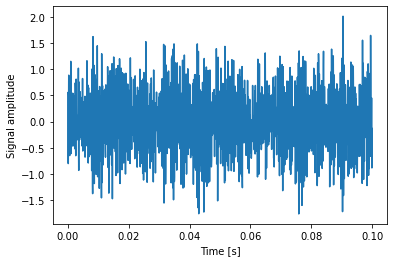

In [173]:
# Zeitsignal anzeigen
t = list(range(0, len(data['acc_x'])))
t = [x / 25600 for x in t]
x = list(data['acc_x'])

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

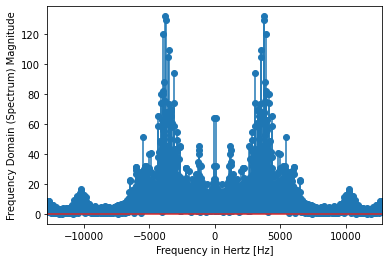

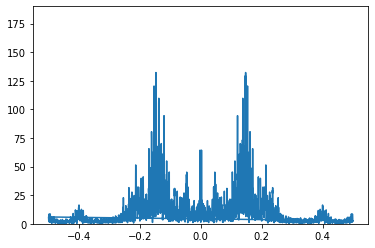

In [190]:
f_s = 25600

win = np.kaiser(len(t), 5)
# win = np.hanning(len(t))
# win = np.hamming(len(t))
# win = np.blackman(len(t))
# win = np.bartlett(len(t))
X_win = fftpack.fft(x * win)
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X_win), use_line_collection=True)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
# ax.set_ylim(-5, 110)
plt.show()

plt.plot(fftpack.fftfreq(len(t)), np.abs(X_win))
plt.ylim(0, 190);

<h3>Referenzen</h3>

<ul>
    <li>Oreilly: <a href=https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html>Chapter 4. Frequency and the Fast Fourier Transform</a>, abgerufen am 12.04.2022</li>
    <li>Dewesoft: <a href=https://dewesoft.com/daq/guide-to-fft-analysis>FFT Analysis (Fast Fourier Transform): The Ultimate Guide to Frequency Analysis</a>, abgerufen am 12.04.2022</li>
    <li>endaqblog: <a href=https://blog.endaq.com/vibration-analysis-fft-psd-and-spectrogram>Vibration Analysis: FFT, PSD, and Spectrogram Basics [Free Download]</a>, abgerufen am 12.04.2022</li>
    <li>NTI-Audio: <a href=https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft>Fast Fourier Transformation FFT - Basics</a>, abgerufen am 12.04.2022</li>
</ul>